## Import das bibliotecas utilizadas


In [39]:
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error



### Carregamento dos dados para a parte de Modelagem

In [2]:
df_transposed_copy_inputting_v19 = pd.read_csv(r'Projeto/Data/Output/df_transposed_copy_inputting_v19.csv')


## Modelagem

Modelos de Forecasting são divididos em partes pré e pós período desejado para previsão. Os períodos utilizados devem ser equiparáveis ao tipo de questão analisada.

In [3]:
df_model = df_transposed_copy_inputting_v19.copy()

In [4]:
df_model['year'] = pd.to_datetime(df_model['year'], format='ISO8601')


In [6]:
df_model = df_model.rename(columns = {'year': 'ds'})
df_model.head(1)

,ds,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Emerging and Developing Europe,Emerging market and developing economies,Euro area,European Union,Latin America and the Caribbean,Major advanced economies (G7),Middle East and Central Asia,Other advanced economies,Sub-Saharan Africa,World
0,1980-01-01,4.345486,2.7,-5.4,2.877381,2.4,8.2,0.7,5.29,5.399885,...,-0.8,3.3,3.988678,1.8,6.4,0.9,-1.9,3.8,3.99192,2.1


#### Training and Test set

In [7]:
test_years = 5
train_data = df_model.iloc[:-test_years, :]
#train_data.tail(1)
test_data = df_model.iloc[-test_years:, :]
#test_data.head(1)

### FB Prophet sem regressor


In [37]:
df_pred_prophet = pd.DataFrame()

for country in df_model.columns:
    train_data_prophet = pd.DataFrame({
        'ds': train_data['ds'],
        'y': train_data[country]
    })
    # # Crie e ajuste o modelo
    model_prophet = Prophet(
        growth='linear',
        seasonality_mode='additive',
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0,
    )
    model_prophet.fit(train_data_prophet)


    future = model_prophet.make_future_dataframe(periods=test_data.shape[0], freq='YS')  
    forecast = model_prophet.predict(future)
    df_pred_prophet = pd.concat([df_pred_prophet, pd.DataFrame(forecast[['yhat']][-5:].values, columns=[country])], axis=1)

22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:57 - cmdstanpy - INFO - Chain [1] done processing
22:21:57 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:22:00 - cmdstanpy - INFO - Chain [1] start processing
22:22:00 - cmdstanpy - INFO - Chain [1]

#### KPIS de Avaliação do Modelo
 Indicadores para medir a performance do modelo. MAE e RSME são indicadores de performance para modelos de regressão com variáveis dependentes contínuas. Não existem indicadores considerados 'perfeitos', existem os indicadores melhores apropriados para o problema analisado.

 - MAE - (Mean Absolute Error) É um indicador mais interpretável, utilizado quando a série temporal trata de taxas, porcentagens.
- RSME -  (Root Square Mean Error) São utilizados para modelos com outliers/extremos.
- MAPE - (Mean Absolute Percentage Error) Apesar de tratar os erros de forma absoluta é considerado um indicador mais agradável para comunicar a respeito do modelo. 

In [17]:
df_pred_prophet[country].index = test_data[country].index
df_pred_prophet.drop(columns='ds', inplace = True)
test_data_drop = test_data.copy()
test_data_drop.drop(columns='ds', inplace = True)
df_pred_prophet.index = test_data_drop.index
df_model_drop = df_model.copy()
df_model_drop.drop(columns = 'ds', inplace = True)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def MAPE(df_model_true, df_model_pred):
    df_model_true, df_model_pred = np.array(df_model_true), np.array(df_model_pred)
    return np.mean(np.abs((df_model_true - df_model_pred)/ df_model_true)) *100

metrics_results = []
# Loop para métricas mae, rmse e mape
for country in df_model_drop.columns:
    mae = round(mean_absolute_error(test_data_drop[country].values, df_pred_prophet[country].values),2)
    rmse = round(np.sqrt(mean_squared_error(test_data_drop[country].values, df_pred_prophet[country].values)), 2)
    mape = MAPE(test_data_drop[country].values, df_pred_prophet[country].values)
    
    print(f"Country: {country}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")
    print("=============")

    metrics_results.append({
        "Country": country,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

metrics_prophet = pd.DataFrame(metrics_results)
metrics_prophet.to_csv('Projeto/Data/Metrics/metrics_prophet.csv', index = True)

Country: Afghanistan
MAE: 0.55
RMSE: 0.59
MAPE: 10.603333670179602
Country: Albania
MAE: 1.14
RMSE: 1.14
MAPE: 33.59900773702405
Country: Algeria
MAE: 0.56
RMSE: 0.65
MAPE: 30.139492078946052
Country: Andorra
MAE: 0.54
RMSE: 0.54
MAPE: 35.846273351605426
Country: Angola
MAE: 0.47
RMSE: 0.53
MAPE: 11.307988570423877
Country: Antigua and Barbuda
MAE: 3.21
RMSE: 3.35
MAPE: 91.78077740527151
Country: Argentina
MAE: 0.36
RMSE: 0.36
MAPE: 18.108764639836565
Country: Armenia
MAE: 3.44
RMSE: 3.47
MAPE: 75.18349718548649
Country: Aruba
MAE: 0.47
RMSE: 0.48
MAPE: 41.43844338392534
Country: Australia
MAE: 0.37
RMSE: 0.45
MAPE: 19.148231401744063
Country: Austria
MAE: 0.41
RMSE: 0.43
MAPE: 25.298247947064255
Country: Azerbaijan
MAE: 7.15
RMSE: 7.17
MAPE: 279.37696673825127
Country: The Bahamas
MAE: 1.09
RMSE: 1.09
MAPE: 68.0729705631594
Country: Bahrain
MAE: 0.44
RMSE: 0.48
MAPE: 15.324865604349187
Country: Bangladesh
MAE: 0.24
RMSE: 0.27
MAPE: 3.5046018482368124
Country: Barbados
MAE: 2.21
RMSE: 

### Export forecasts 

In [35]:
## Export forecast

df_pred_prophet.to_csv('Projeto/Data/Output/predictions_prophet_all.csv', index = True)

### Avaliando Métricas

DataFrame: Prophet
Métrica: MAE
mean      1.588991
median    0.870000
std       1.970367
Name: MAE, dtype: float64


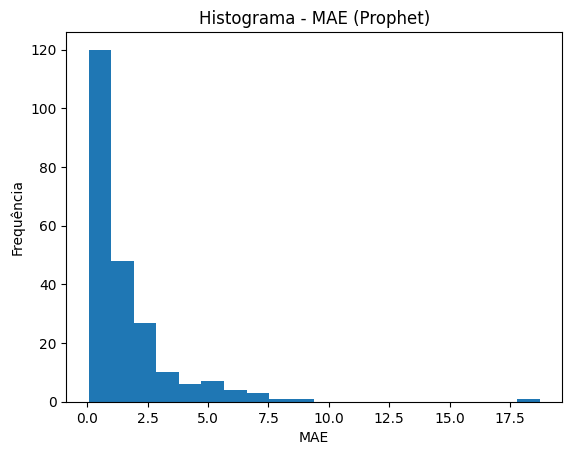



Top 20 MAE (Prophet):
                     Country    MAE   RMSE         MAPE
71                    Guyana  18.72  19.19   317.526057
193                    Yemen   8.55   8.77   169.880919
53         Equatorial Guinea   7.86   8.90   437.694374
11                Azerbaijan   7.15   7.17   279.376967
96                   Lebanon   6.81   6.84    70.088076
190                Venezuela   6.77   7.03   706.453191
171               Tajikistan   6.29   6.32   154.295464
132                    Palau   6.25   6.66   134.588373
161  Republic of South Sudan   6.20   6.20   138.407373
141                    Qatar   6.00   6.02   215.540764
179             Turkmenistan   5.46   5.47   236.681101
176                    Tonga   5.32   5.32   255.300999
63                   Georgia   5.20   5.24   100.698901
199                Caribbean   4.92   6.67    61.552635
102                Macao SAR   4.80   7.00    55.731414
40         Republic of Congo   4.80   4.82   119.060018
81                   Ire

In [40]:

# Lista de métricas
metrics = ['MAE']

# Dicionário de DataFrames com seus respectivos nomes
dataframes = {
    'Prophet': metrics_prophet,
}

# Iterar sobre os DataFrames e as métricas
for df_name, df in dataframes.items():
    print(f"DataFrame: {df_name}")
    
    for metric in metrics:
        print(f"Métrica: {metric}")
        
        # Agregar as estatísticas
        aggregated = df[metric].agg(['mean', 'median', 'std'])
        print(aggregated)
        
        # Gerar histograma
        plt.hist(df[metric], bins=20)
        plt.title(f"Histograma - {metric} ({df_name})")
        plt.xlabel(metric)
        plt.ylabel("Frequência")
        plt.show()

        print("\n")

    # Mostrar os top 20 valores maiores de MAE
    top_20 = df.sort_values(by='MAE', ascending=False).head(20)
    print(f"Top 20 MAE ({df_name}):\n{top_20}\n")
